In [147]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [148]:
import sys
sys.path.append("../Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [149]:
USE_CUDA = False

## Import data and topology

In [434]:
Timeseries = pd.read_csv('../Network-SDE-Inference/Data/TimeSeries&Topologies/Lorenz_stochastic_in005_200.csv',encoding='utf-8',header=None)

In [435]:
Adj = pd.read_csv('../Network-SDE-Inference/Data/TimeSeries&Topologies/unweighted_adj_20nodes.csv',encoding='utf-8',header=None)

In [436]:
Adj.shape[0]

20

In [437]:
Num_nodes = 20
Dimension = 3
dim = Dimension*1

In [438]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [439]:
delt_t = 0.01

## Calculate the numerical difference

In [440]:
timeseries_t0 = timeseries[:-2,:,:]
timeseries_t1 = timeseries[1:-1,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [441]:
data = np.concatenate((timeseries[:-2,:,:],dXdt),axis=2)

## Check the topology and edge list (source to target)

In [442]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [443]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

## Construct the data, inluding goal and input data

In [444]:
#data = data.reshape((10,-1,4,6))
import numpy as np
#goal_data = np.concatenate((data[1:-1,:,0:Dimension],data[0:-2,:,Dimension:Dimension*2]),axis=2)
goal_data = data[1:-1,:,0:Dimension]
mapping_data = data[0:-2,:,0:Dimension]

In [445]:
#tmp1 = np.concatenate([mapping_data[:, i] for i in range(0, mapping_data.shape[1], 1)])
#tmp2 = np.concatenate([goal_data[:, i] for i in range(0, goal_data.shape[1], 1)])
#X = torch.from_numpy(mapping_data)
#y = torch.from_numpy(goal_data)

X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [446]:
from sklearn.model_selection import train_test_split

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [448]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.data import Data, DataLoader

In [449]:
aggr = 'add'
hidden = 100
model = 'Lorenz'
msg_dim = 1
n_f = mapping_data.shape[2]

## Instant model

In [450]:
ogn = SDIunweighted(model, n_f, msg_dim, Dimension, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

## Use these "_over_time" to save estimated values

In [451]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
ogn = ogn

In [452]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [453]:
ogn.loss(_q)

tensor(9.1204, grad_fn=<AddBackward0>)

In [454]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=256,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [455]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [456]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 50

batch_per_epoch = 1000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

1000

In [457]:
epoch = 0
from tqdm import tqdm

In [458]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

# newtestloader = DataLoader(
#     [Data(
#         X_train[i],
#         edge_index=edge_index,
#         y=y_train[i]) for i in test_idxes],
#     batch_size=len(X_train),
#     shuffle=False
# )

In [459]:
test_idxes.shape

(1000,)

In [460]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        #print(s1)
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        #print(s2)
        tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        tmp = tmp.reshape(2,-1)
        tmp = tmp.t()# tmp has shape [E, 2 * in_channels]

        m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            tmp,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
#     if dim == 1:
#         msg_info['dx'] = msg_info.x1 - msg_info.x2
#         msg_info['dy'] = msg_info.y1 - msg_info.y2
#         msg_info['dz'] = msg_info.z1 - msg_info.z2
#         msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2(msg_info.dy)**2 + (msg_info.dz)**2)
#     else:
#         msg_info['dx'] = msg_info.x1 - msg_info.x2
#         msg_info['dy'] = msg_info.y1 - msg_info.y2
#         if dim == 2:
#             msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2 + (msg_info.dy)**2
#             )
#         elif dim == 3:
#             msg_info['dz'] = msg_info.z1 - msg_info.z2
#             msg_info['r'] = np.sqrt(
#                 (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
#             )
    
    return msg_info

In [461]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [ ]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['x','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['x','y','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['x','y','z','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [463]:
recorded_models = []

## Start training

In [464]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())


  0%|                                                    | 0/50 [00:00<?, ?it/s]

0.10400630656187107
0.021592740309888333



  2%|▊                                        | 1/50 [01:51<1:31:12, 111.69s/it]

0.08112147538194121
0.020000278350945047



  4%|█▋                                       | 2/50 [03:42<1:28:59, 111.24s/it]

0.07392491075615067
0.01790314164686789



  6%|██▍                                      | 3/50 [05:33<1:26:55, 110.97s/it]

0.06798943917647134
0.01700162009026408



  8%|███▎                                     | 4/50 [07:24<1:25:02, 110.92s/it]

0.06554097119380424
0.01659898885740537



 10%|████                                     | 5/50 [09:14<1:23:08, 110.86s/it]

0.06400896500310072
0.016170420332320485



 12%|████▉                                    | 6/50 [11:06<1:21:23, 110.99s/it]

0.061906022046173764
0.015505103612261902



 14%|█████▋                                   | 7/50 [12:56<1:19:29, 110.92s/it]

0.05973800050844928
0.015224917306218392



 16%|██████▌                                  | 8/50 [14:47<1:17:29, 110.70s/it]

0.059137806476127534
0.015113331501460119



 18%|███████▍                                 | 9/50 [16:37<1:15:35, 110.63s/it]

0.05874859293364
0.015076570819261467



 20%|████████                                | 10/50 [18:27<1:13:41, 110.55s/it]

0.05857420820530231
0.015078014145658424



 22%|████████▊                               | 11/50 [20:18<1:11:50, 110.53s/it]

0.05839157401080906
0.014982928868286867



 24%|█████████▌                              | 12/50 [22:09<1:10:00, 110.55s/it]

0.058269608324077966
0.01494949001037986



 26%|██████████▍                             | 13/50 [23:59<1:08:10, 110.55s/it]

0.058145273441209296
0.014938924975534945



 28%|███████████▏                            | 14/50 [25:50<1:06:23, 110.65s/it]

0.05804160592212761
0.014876935139988766



 30%|████████████                            | 15/50 [27:41<1:04:31, 110.62s/it]

0.05797562648663262
0.014910966361960334



 32%|████████████▊                           | 16/50 [29:31<1:02:36, 110.49s/it]

0.057888349875991264
0.014872723907644193



 34%|█████████████▌                          | 17/50 [31:21<1:00:46, 110.49s/it]

0.057860291607045915
0.01488075430436088



 36%|███████████████                           | 18/50 [33:12<58:56, 110.51s/it]

0.05781866747818642
0.01491118990798298



 38%|███████████████▉                          | 19/50 [35:02<57:06, 110.54s/it]

0.05777934489640965
0.014880556423462105



 40%|████████████████▊                         | 20/50 [36:53<55:18, 110.61s/it]

0.05772545295647847
0.01484771436049348



 42%|█████████████████▋                        | 21/50 [38:44<53:26, 110.58s/it]

0.057690687881392706
0.014841075383063805



 44%|██████████████████▍                       | 22/50 [40:34<51:35, 110.55s/it]

0.057660907933568484
0.014813525122138646



 46%|███████████████████▎                      | 23/50 [42:25<49:47, 110.64s/it]

0.05764953274648473
0.014857115347480907



 48%|████████████████████▏                     | 24/50 [44:15<47:54, 110.57s/it]

0.05760721375795128
0.014827939688144878



 50%|█████████████████████                     | 25/50 [46:06<46:04, 110.58s/it]

0.057598614443791926
0.014839005129498107



 52%|█████████████████████▊                    | 26/50 [47:56<44:13, 110.55s/it]

0.057558353020860646
0.014792016090213536



 54%|██████████████████████▋                   | 27/50 [49:47<42:22, 110.54s/it]

0.05755280079435928
0.014798199985341279



 56%|███████████████████████▌                  | 28/50 [51:38<40:32, 110.56s/it]

0.057524162031243935
0.014800912183562843



 58%|████████████████████████▎                 | 29/50 [53:28<38:42, 110.57s/it]

0.05749265025494702
0.0148176835186728



 60%|█████████████████████████▏                | 30/50 [55:20<36:58, 110.92s/it]

0.05747772857845817
0.014796634087644638



 62%|██████████████████████████                | 31/50 [57:13<35:17, 111.46s/it]

0.05743916984676622
0.01479861516212758



 64%|██████████████████████████▉               | 32/50 [59:05<33:33, 111.83s/it]

0.05743793501305179
0.014828309610329658



 66%|██████████████████████████▍             | 33/50 [1:00:58<31:44, 112.06s/it]

0.05740032333459393
0.014779428299969347



 68%|███████████████████████████▏            | 34/50 [1:02:50<29:52, 112.05s/it]

0.05739158749647451
0.01477824755457316



 70%|████████████████████████████            | 35/50 [1:04:42<27:59, 112.00s/it]

0.0573731498911417
0.014801168830987588



 72%|████████████████████████████▊           | 36/50 [1:06:34<26:08, 112.05s/it]

0.057350870597479515
0.014784086825545864



 74%|█████████████████████████████▌          | 37/50 [1:08:26<24:16, 112.04s/it]

0.05733357205676788
0.01476161219208235



 76%|██████████████████████████████▍         | 38/50 [1:10:18<22:24, 112.02s/it]

0.05731469835051374
0.014771530206837495



 78%|███████████████████████████████▏        | 39/50 [1:12:11<20:34, 112.23s/it]

0.05729821900945235
0.014759945034568865



 80%|████████████████████████████████        | 40/50 [1:14:03<18:43, 112.31s/it]

0.057285271771752834
0.014773795158548186



 82%|████████████████████████████████▊       | 41/50 [1:15:56<16:51, 112.40s/it]

0.05726982708192508
0.014757282643869524



 84%|█████████████████████████████████▌      | 42/50 [1:17:48<14:59, 112.45s/it]

0.05725880210799203
0.01475060059628677



 86%|██████████████████████████████████▍     | 43/50 [1:19:41<13:07, 112.57s/it]

0.057244802882032424
0.014749975395890676



 88%|███████████████████████████████████▏    | 44/50 [1:21:34<11:15, 112.64s/it]

0.057231476912463004
0.014748114553793391



 90%|████████████████████████████████████    | 45/50 [1:23:26<09:22, 112.50s/it]

0.05722449281822706
0.014748900657744245



 92%|████████████████████████████████████▊   | 46/50 [1:25:18<07:29, 112.38s/it]

0.05721630616106674
0.014748479612219324



 94%|█████████████████████████████████████▌  | 47/50 [1:27:11<05:37, 112.36s/it]

0.05720942653983416
0.014746053932396261



 96%|██████████████████████████████████████▍ | 48/50 [1:29:03<03:44, 112.30s/it]

0.05720510755977594
0.014745605700928933



 98%|███████████████████████████████████████▏| 49/50 [1:30:55<01:52, 112.28s/it]

0.05720260508874062
0.01474531700857039


100%|████████████████████████████████████████| 50/50 [1:32:47<00:00, 111.36s/it]


In [345]:
#torch.save(ogn, 'Lorenz_N20_intensity1_t50_net.pth')

In [182]:
#ogn = torch.load('Lorenz_N20_intensity1_t150_net.pth')

In [465]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# #ax1.scatter(s.index, s.values)
# ax1.plot(s.index, s.values,'.')
# plt.grid()
 
# ax2 = fig.add_subplot(2,1,2) 
# s.hist(bins=30,alpha = 0.5,ax = ax2)
# s.plot(kind = 'kde', secondary_y=True,ax = ax2)
# plt.title('The standard deviation distribusion')
# plt.grid()

In [466]:
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
 
sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )
np.random.seed(1425)

In [522]:
from matplotlib import colors as mcolors

In [523]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

## Check the accuracy

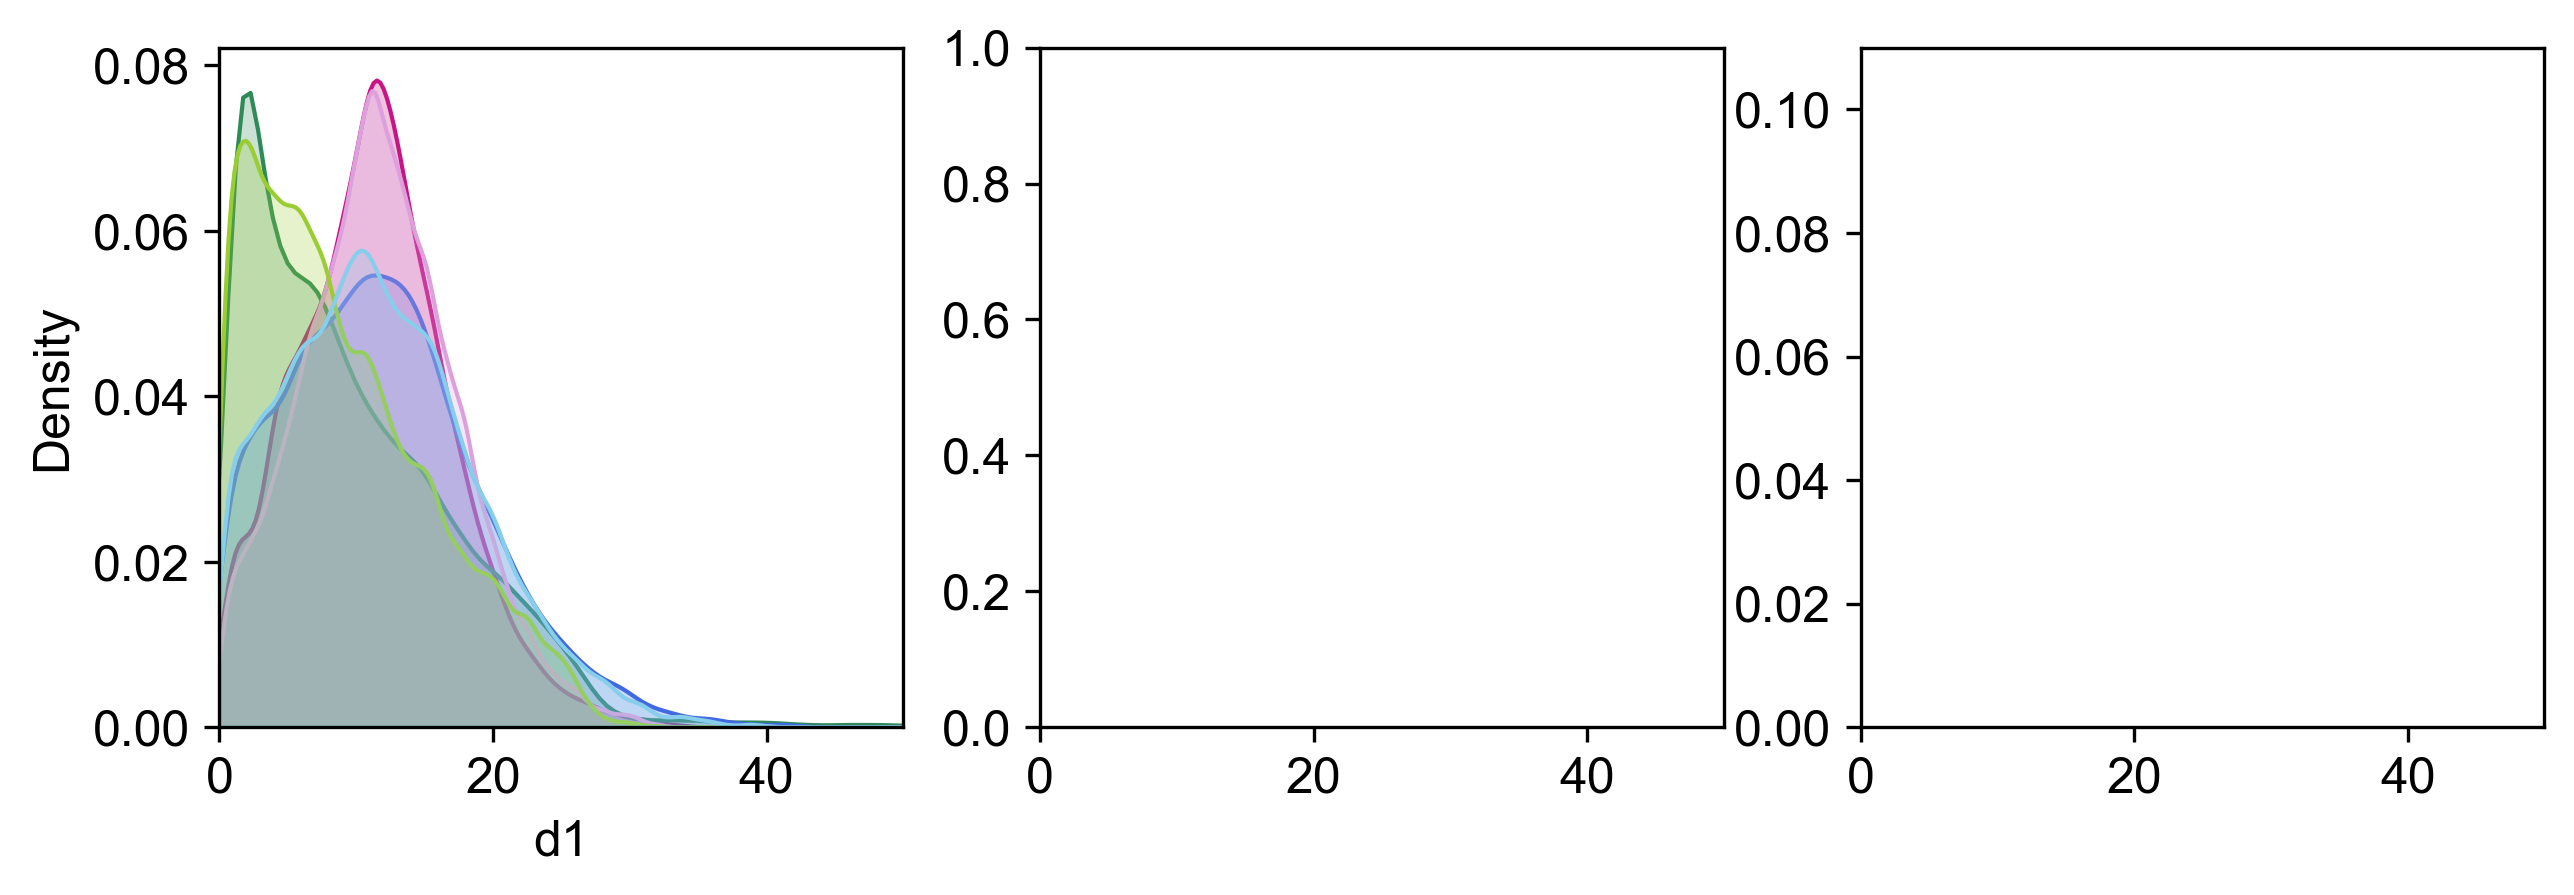

In [540]:
gamma = 1
s = diffusion_new['d1']/np.sqrt(0.01)
s1 = diffusion['x'].abs()/np.sqrt(gamma)
s2 = diffusion_new['d2']/np.sqrt(0.01)
tmp1 = (28-diffusion['z'])/np.sqrt(gamma)
s3 = tmp1.abs()/np.sqrt(gamma)
s4 = diffusion_new['d3']/np.sqrt(0.01)
s5 = diffusion['y'].abs()/np.sqrt(gamma)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(10, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)

sns.kdeplot(s, shade=True, color=colors['mediumvioletred'], label='dist1', ax=ax1)
#sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['seagreen'], label='dist1', ax=ax1)
#sns.kdeplot(s3, shade=True, color=colors['mistyrose'], label='dist2',ax=ax1)
sns.kdeplot(s4, shade=True, color=colors['royalblue'], label='dist1', ax=ax1)
#sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax1)

sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s3, shade=True, color=colors['yellowgreen'], label='dist2',ax=ax1)
sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax1)
plt.xlim([0, 50])
plt.ylim([0, 0.11])
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_dif_fig2.pdf')

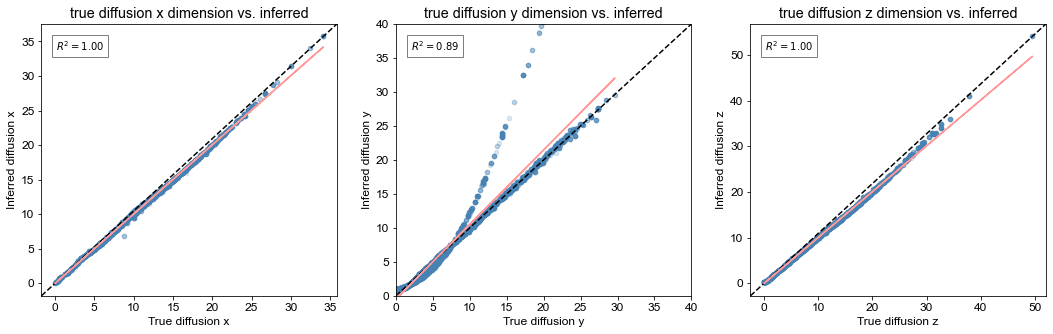

In [469]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})

gamma = 1
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
sx = diffusion['d1'].values/np.sqrt(0.01)
sx_true = np.abs(diffusion['x'].values/np.sqrt(gamma))
sy = diffusion['d2'].values/np.sqrt(0.01)
sy_true = np.abs((28-diffusion['z'])/np.sqrt(gamma))
sz = diffusion['d3'].values/np.sqrt(0.01)
sz_true = np.abs(diffusion['y']/np.sqrt(gamma))

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true diffusion x dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c = '#ff9999', lw=1.5)

ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
#sb.regplot(sx_true,sx, fit_reg = Fals,
           #x_jitter = 1e-5, y_jitter = 1e-5, scatter_kws = {'alpha' : 1/3})
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion x")
plt.ylabel("Inferred diffusion x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true diffusion y dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c = '#ff9999', lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=10, bbox=bbox)
plt.xlim([0, 40])
plt.ylim([0, 40])
plt.xlabel("True diffusion y")
plt.ylabel("Inferred diffusion y")

ax3 = fig.add_subplot(1,3,3)
plt.title("true diffusion z dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fx(sz_true),c = '#ff9999', lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion z")
plt.ylabel("Inferred diffusion z")
#plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t50_diffusion_accuracy.pdf')
plt.show()
plt.close()


## Check if the well-trained network can produce the similar trajectories

In [470]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [471]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
for i in range(5000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp, y_tmp, z_tmp = ogn.average_trajectories(_q)
    X_tmp = torch.cat((x_tmp,y_tmp,z_tmp), 1)
    if i < X.shape[0]-2:
        X[i+1] = X_tmp
    else:
        break
    x_Update.append(x_tmp.reshape(1,-1))
    y_Update.append(y_tmp.reshape(1,-1))
    z_Update.append(z_tmp.reshape(1,-1))   
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)

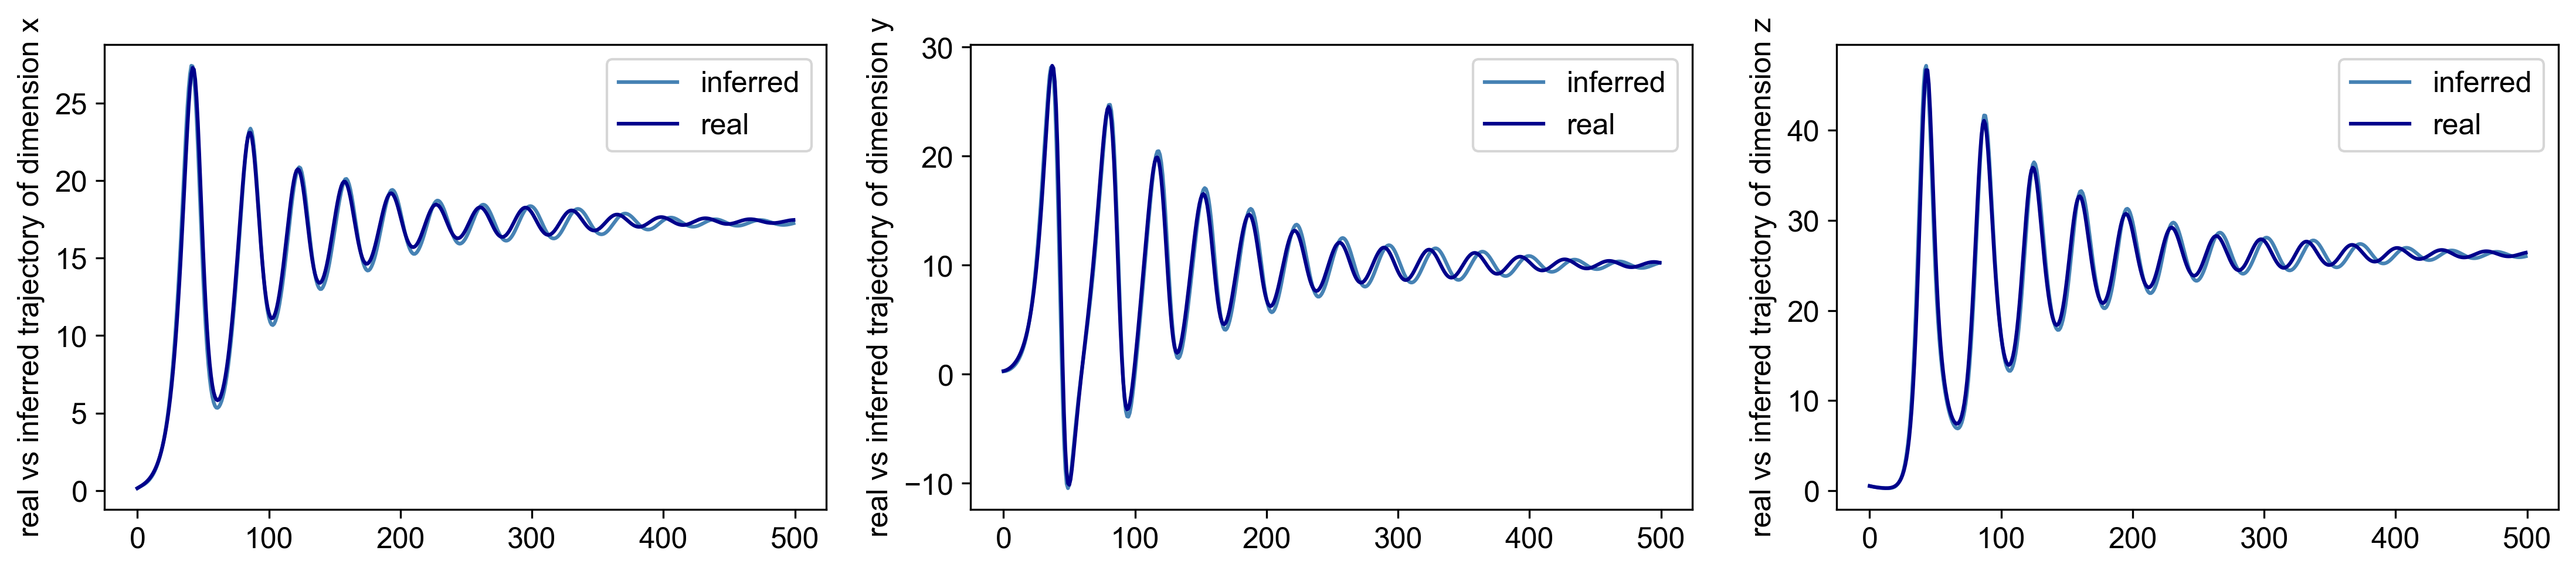

In [518]:
time1 = pd.read_csv('../Network-SDE-Inference/Data/TimeSeries&Topologies/Lorenz_determ_in005_200.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
x_tra = x_i.detach().numpy()[0:500,0]
x_real = time1.iloc[:,0]
fig = plt.figure(figsize=(18,3.5))
ax1 = fig.add_subplot(1,3,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
y_tra = y_i.detach().numpy()[0:500,0]
y_real = time1.iloc[:,1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
z_tra = z_i.detach().numpy()[0:500,0]
z_real = time1.iloc[:,2]
t = np.arange(0,z_tra.shape[0])
ax3.plot(t,z_tra,c='steelblue',label="inferred")
ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension z')
plt.legend()
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_trajectory_fig2.pdf')
plt.show()
plt.close()

In [473]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])

In [474]:
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2']]

In [475]:
#coup_value = 0.15*(2-bestMe['x1'].values)/(1+np.exp(-10*(bestMe['x2'].values-1))) # x1 (x_i) is target, x2 (x_j) is source 
coup_value = bestMe['x2'].values

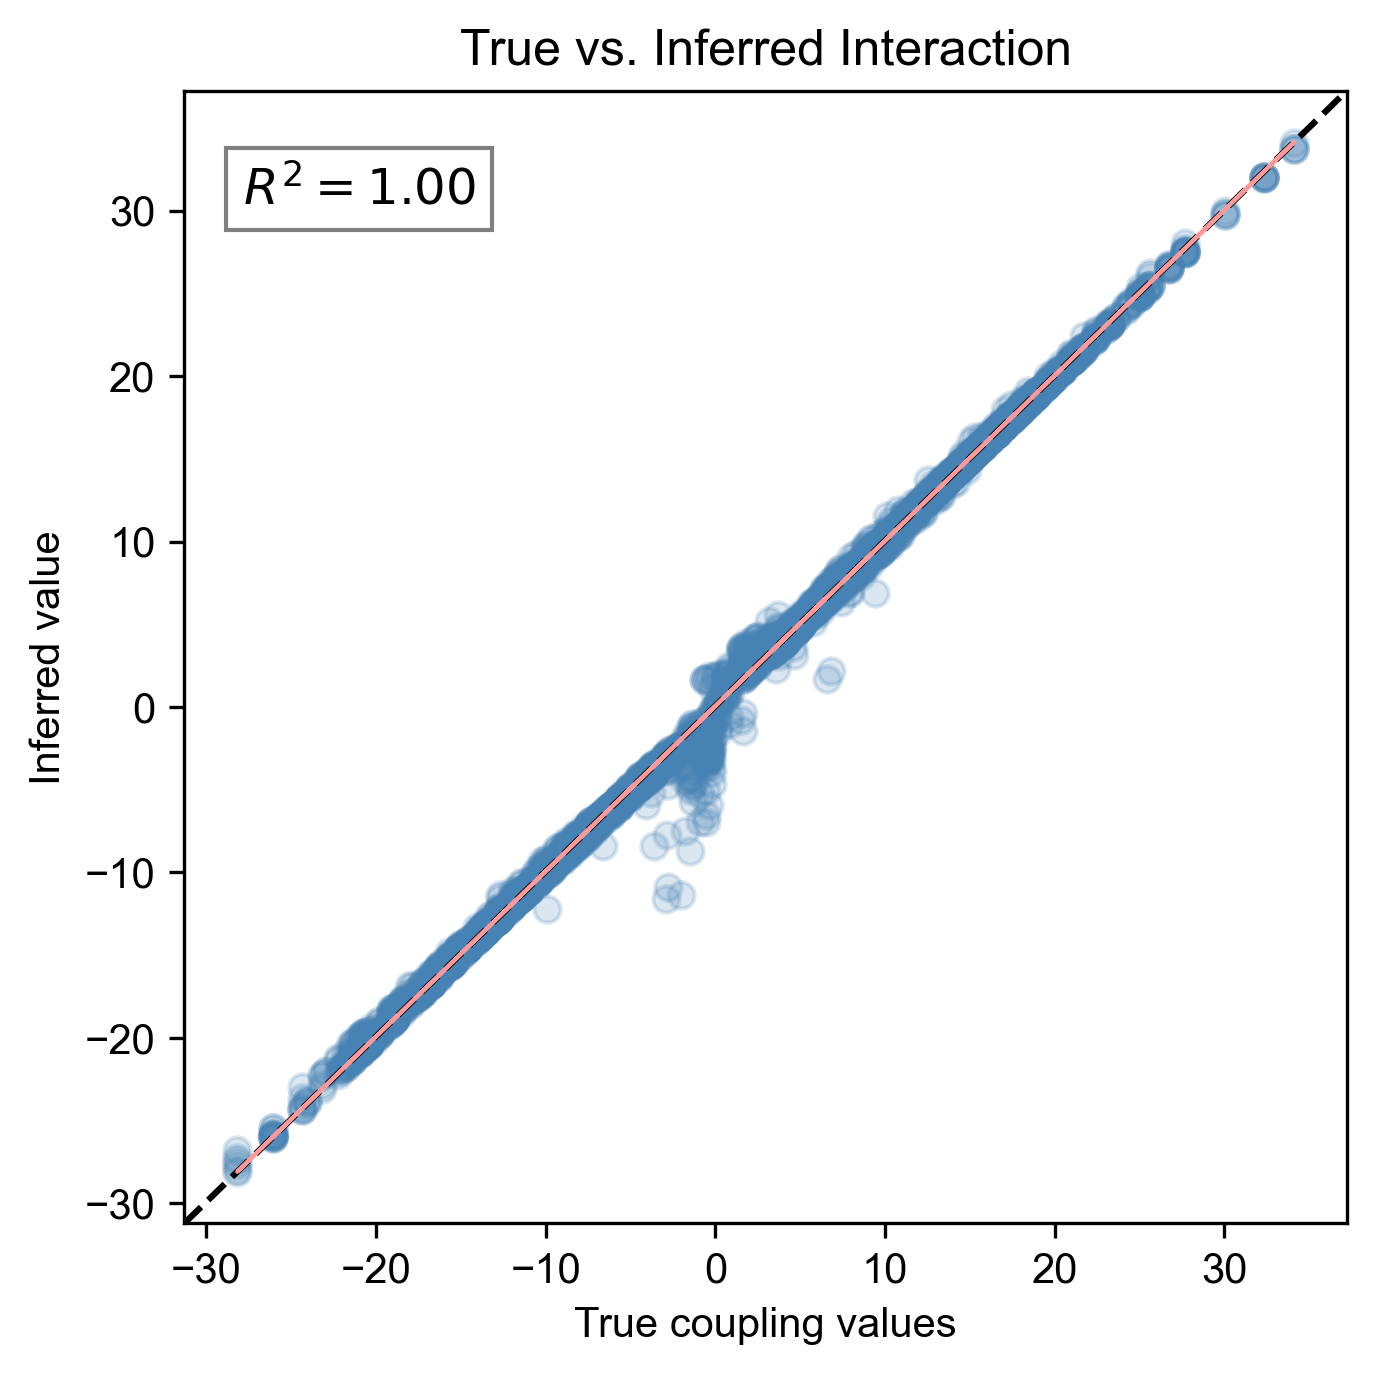

In [519]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2']]
temp = bestMe.iloc[:,0].values
coup_value = coup_value[0:5000]
temp = temp[0:5000]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=40,c ='steelblue', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.0)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
plt.title('True vs. Inferred Interaction')
plt.xlabel("True coupling values")
plt.ylabel("Inferred value")
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_interaction_fig2.pdf')
plt.show()
plt.close()


In [477]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

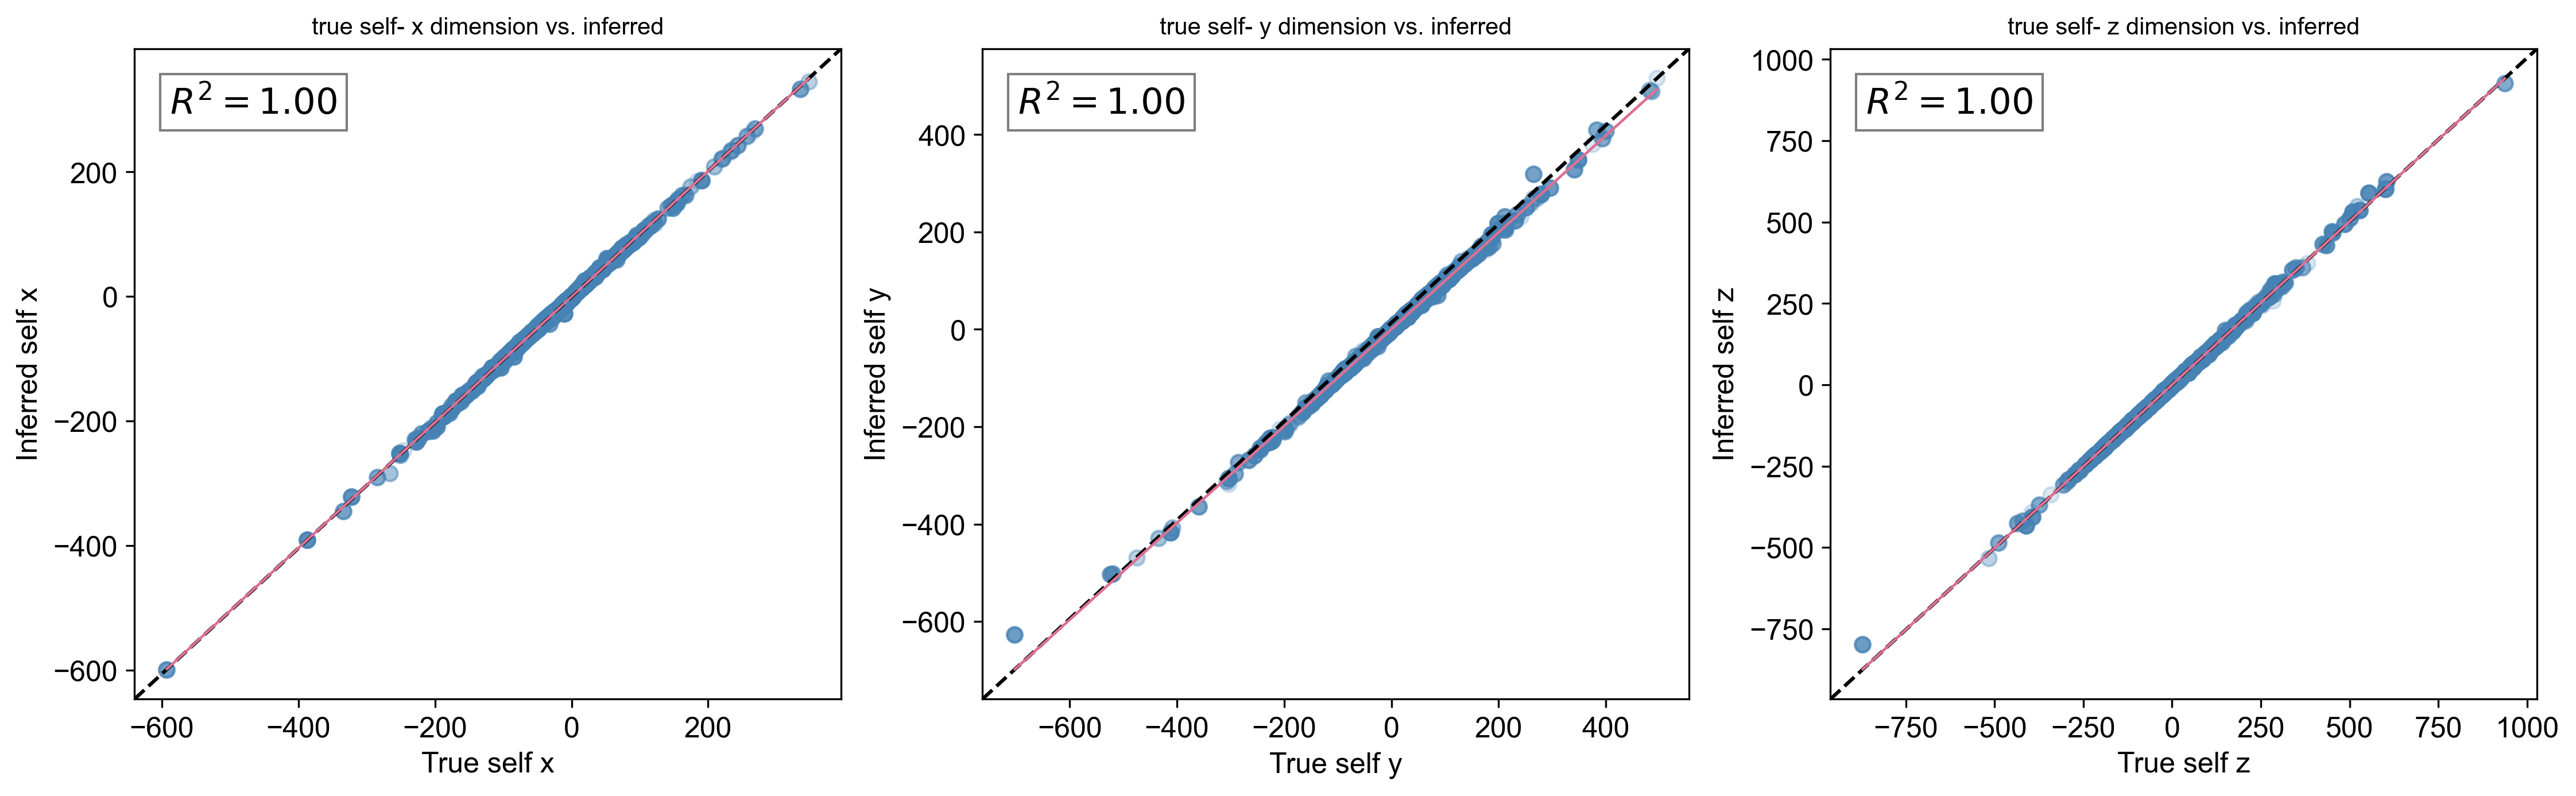

In [520]:
gamma = 1
sx = best_selfDyn['s1'].values
sx_true = 10*best_selfDyn['y']-(10+2/gamma)*best_selfDyn['x']
sy = best_selfDyn['s2'].values
sy_true = (28-best_selfDyn['z'])*best_selfDyn['x']-(1+2/gamma)*best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = best_selfDyn['x']*best_selfDyn['y']-(8/3+4/gamma)*best_selfDyn['z']

plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
sx = best_selfDyn['s1'].values
# sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
# sy = best_selfDyn['s2'].values
# sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
# sz = best_selfDyn['s3'].values
# sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])
sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=40,c ='steelblue', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=40,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='palevioletred',lw=1)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=40,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='palevioletred',lw=1)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
plt.savefig('../Network-SDE-Inference/Results/Figures/Lorenz_N20_intensity1_t200_fig2.pdf')
plt.show()
plt.close()

## Learn the stochastic differential equations

In [479]:
import Self_func

In [480]:
import Interaction_func

In [481]:
from Self_func import *
from Interaction_func import *

In [482]:
"""Construct the elementary matrix with pre-defined library"""
xi = bestMe['x1'].values
xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:114: RuntimeWarning: overflow encountered in exp
  tmp2 = np.exp(xi*xj)
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:141: RuntimeWarning: overflow encountered in exp
  sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: overflow encountered in exp
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: invalid value encountered in true_divide
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


In [483]:
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [484]:
goal = bestMe['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])

In [485]:
X = Matrix.copy()
y = goal.copy()

In [486]:
"""Normalization process, eliminate order of magnitude differences"""
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [487]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=1000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.998284559747808
Best threshold: 0.004


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [488]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

In [489]:
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
fracxixj              -0.000021
xifracxj               0.000619
xisinxj                0.001947
fracxj                 0.002733
sinxj                  0.003039
xisigmoidxj101         0.011152
sigmoidXjMinusXi101    0.041135
sigmoidxj101           0.041800
tanhxj                 0.305873
xj                     0.968971
dtype: float64


In [490]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [491]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept,  n_jobs=-1, max_iter=1000, normalize=False).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [492]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = Matrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = Matrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X)
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])
    if Score>0.95:
        break

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0    1.000574
dtype: float32
0.9979641597857751 0.28054515 -127100.06212542194 xj


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


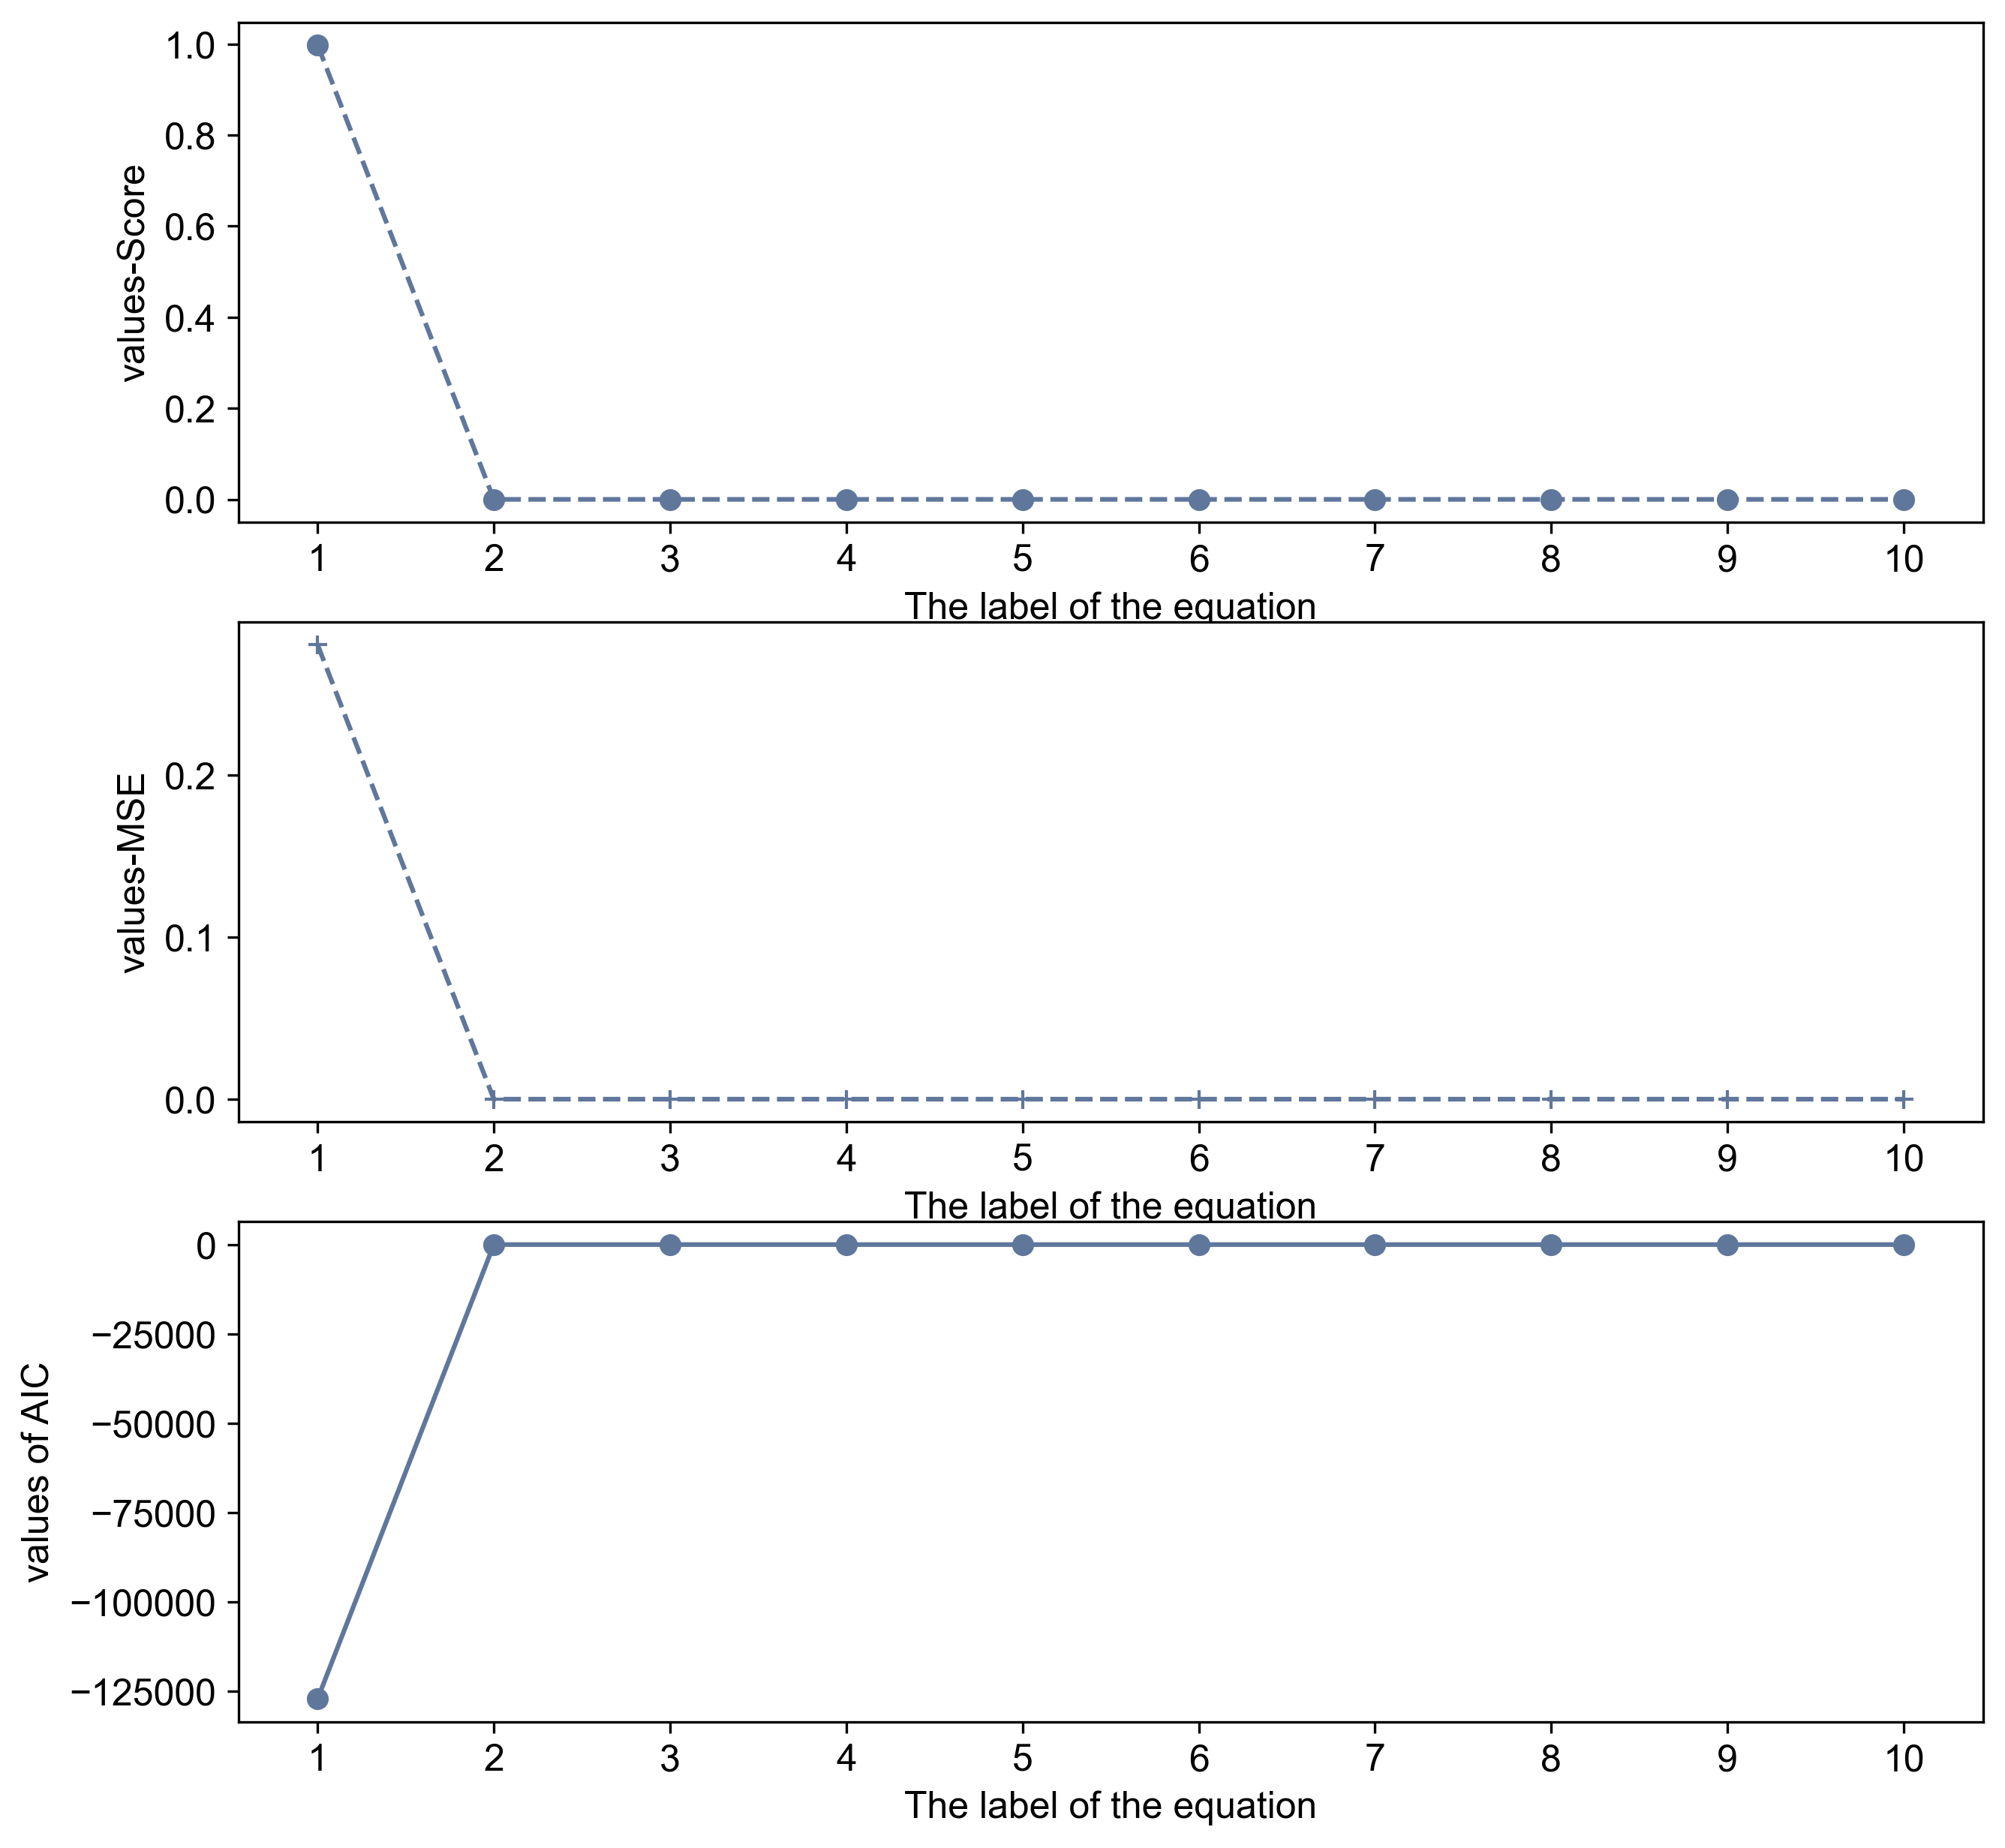

In [493]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

In [494]:
xi = bestMe['x1'].values
xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = bestMe['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])
X = Matrix.copy()
y = goal.copy()

/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:114: RuntimeWarning: overflow encountered in exp
  tmp2 = np.exp(xi*xj)
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:141: RuntimeWarning: overflow encountered in exp
  sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: overflow encountered in exp
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lanag/OneDrive/Project2-StochasticDynamics/utils/Interaction_func.py:145: RuntimeWarning: invalid value encountered in true_divide
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


In [495]:
Xfind = X['xj'].values.reshape(-1,1)
yfind = y['e0']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
print(a)

[1.0015744]


In [496]:
error_int = abs(a-1)/(abs(a)+1)
print('The error of interaction part:',error_int)

The error of interaction part: [0.00078658]


In [497]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [498]:
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [499]:
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])

In [500]:
X = self_matrix.copy()
y = goal.copy()

In [501]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [502]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9991183355806511
Best threshold: 0.006


In [503]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [504]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
#imp_cons = imp_cons.sort_values(key=abs)
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x2x2x3x3    3.402874e-07
x1x2x2x2    2.690227e-06
x1x1x1x1   -4.364229e-06
x2x2x2x3    5.281792e-06
x2x2x2      1.582704e-04
x1x1x1     -4.098657e-04
x1x1       -2.305346e-03
x1x3       -4.437107e-03
x2          9.677019e+00
x1         -1.157163e+01
dtype: float64


In [505]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
        Score, mse, aic = terms_sort_fit(X,y,False)
    else:
        Score, mse, aic = terms_sort_fit(X,y,True)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])
    if Score>0.997:
        break

0   -3.376604
dtype: float64
0.17539433385753533 5984.239025168461 869690.4462902104 x1
0    -12.104348
x2    10.054381
dtype: float64
0.9993006445054974 5.0752870305229685 162442.30810670383 x2


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/a

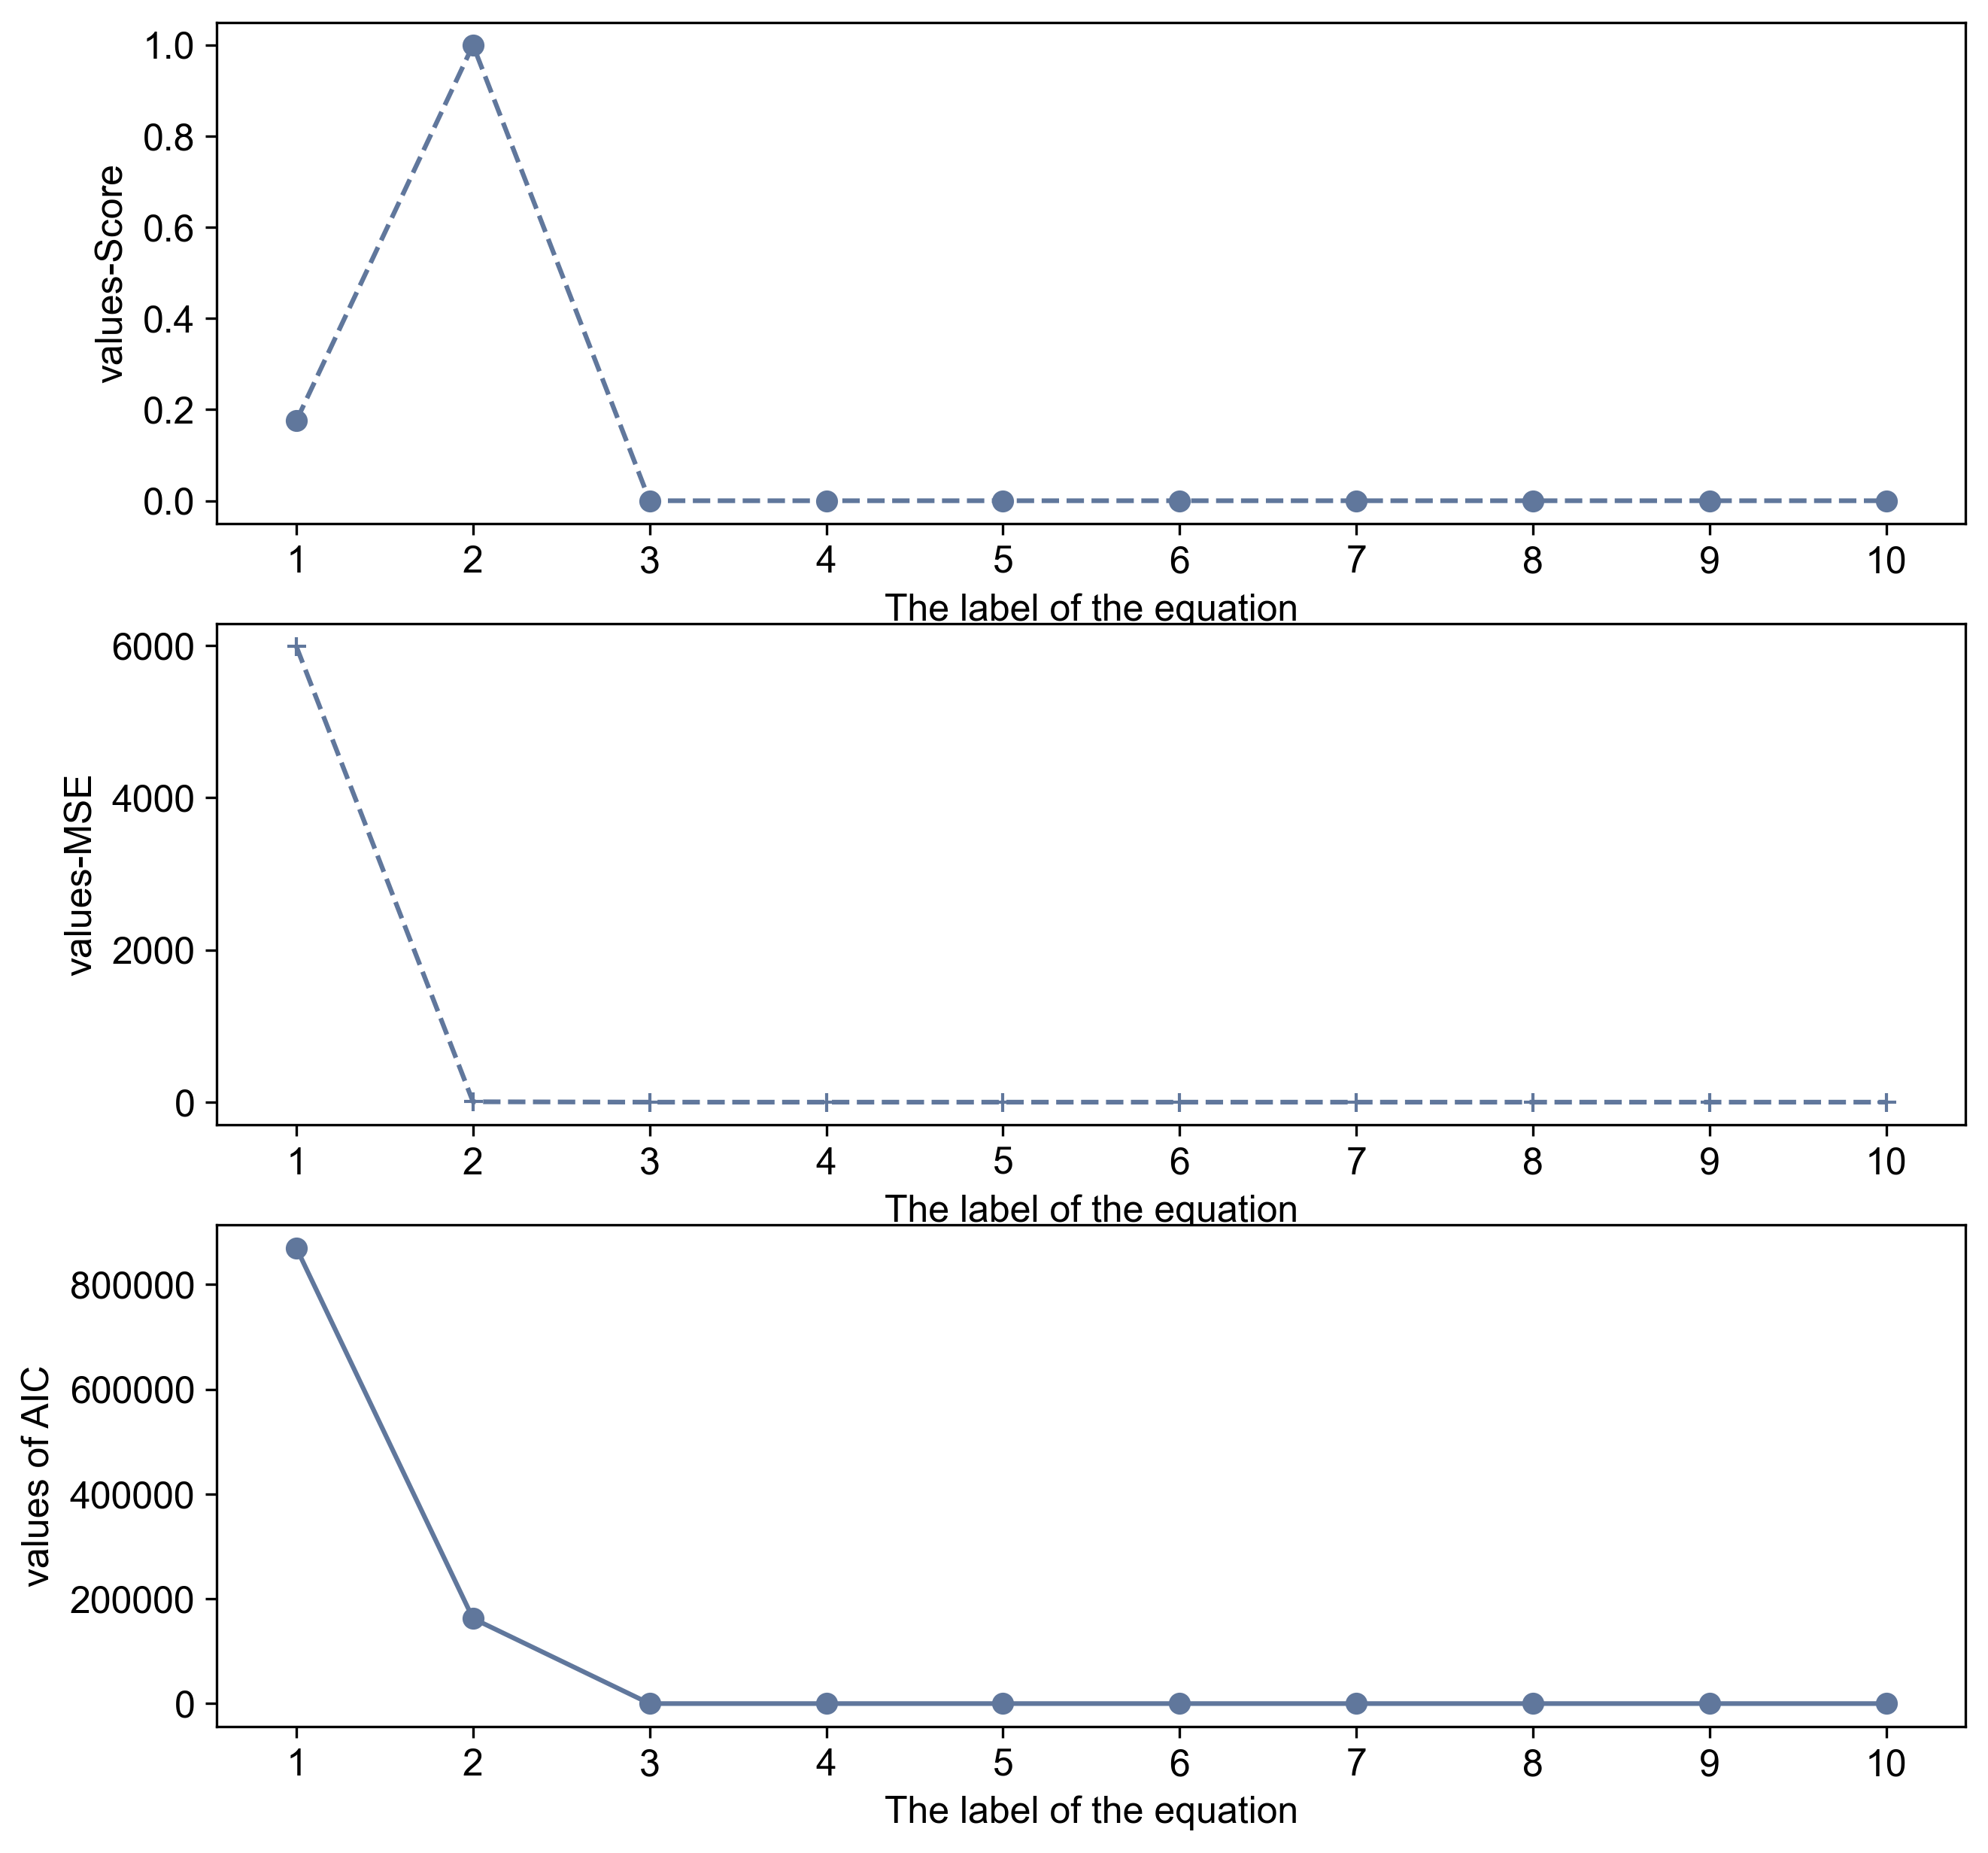

In [506]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

# Calculate the inference error 

In [507]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])
X = self_matrix.copy()
y = goal.copy()

In [508]:
Xfind = pd.concat([X['x1'],X['x2']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s1']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
a

array([-12.12511225,  10.07386531])

In [509]:
model_linear.intercept_

0.0

In [510]:
error_self1 = abs(a[0]-[-12])/(abs(a[0])+abs(-12))

In [511]:
error_int

array([0.00078658], dtype=float32)

In [512]:
error_self2 = abs(a[1]-[10])/(abs(a[1])+abs(10))

In [513]:
Error = (error_self1+error_self2+error_int)/3

In [514]:
Error

array([0.00321741])

In [544]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = best_selfDyn['s3'].values
goal = pd.DataFrame(data = goal, columns =['s3'])
X = self_matrix.copy()
y = goal.copy()

In [545]:
Xfind = pd.concat([X['x1x2'],X['x3']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s3']
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_
a

array([ 1.00233568, -6.67988203])